In [2]:
import ticktack
from jax.numpy import array, pi, exp, sin, mean, median, var, arange, sum
from numpy import random
from scipy.stats import ttest_ind
from pandas import read_csv, DataFrame, concat
from plotnine import ggplot, facet_wrap, labs, aes, theme_bw, geom_tile, scale_color_cmap
from os import listdir

The basic question is what is the probability of detecting consecutive events based on the distribution of the data. The first step then will be to determine the distribution of the data. This will be done be resampling the points after the event has been removed.

In [3]:
models = { # This dictionary contains the units for the fluxes and production function
    "Guttler14": {  # Units of the Guttler 2014 paper
        "production_rate_units": "atoms/cm^2/s",    # Units of the production rate 
        "flow_rate_units": "Gt/yr"                  # Units of the fluxes
    },
    "Brehm21": {    # Units used by the Brehm, et. al. paper
        "production_rate_units": "kg/yr",    # Units of the production rate
        "flow_rate_units": "Gt/yr"           # Units of the fluxes
    },
    "Buntgen18": {  # The units used by the Buntgen 2018 paper
        "production_rate_units": "atoms/cm^2/s",    # Units of the production function
        "flow_rate_units": "Gt/yr"                  # Units of the fluxes 
    },
    "Miyake17": {   # The units used by the Miyake 2017 et. al. paper
        "production_rate_units": "atoms/cm^2/s",    # Units of the production function 
        "flow_rate_units": "1/yr"                   # Units of the fluxes.
    }
}

In [4]:
data_sets = []  # An empty list to store the datasets
for file in listdir():  # Looping through the files in the directory 
    if file.endswith(".csv"):   # Checking the file extension looking for .csv
        data_sets.append(file)  # Appending the data file to my list of data files

The function below will also have a `shape` parameter eventually. First however I want to get this running. Damn this really is well suited to a class structure since then I can set `self.set_annual_samples()` need to check if this has actually been implemented. The answer is __No__. I need to add the growth seasons to the `model_units` (which I might just rename `models`). This will lead to ?two? extra field `hemisphere_model` (bool) and `growth_seasons`. Alternatively this could result in a further nested dictionary like `hemispheres = {"NH_growth": array([]), "SH_growth": array([])}`

In [5]:
def get_model(model: str):
    cbm = ticktack.load_presaved_model( # Generating the CarbobBoxModel using ticktack
        model,  # Name of the model as looped from the models dictionary 
        production_rate_units=models[model]["production_rate_units"], 
        flow_rate_units=models[model]["flow_rate_units"]
    )

    bayesian_model = ticktack.fitting.SingleFitter(model)   # Fitting a model 
    bayesian_model.prepare_function(model="simple_sinusoid")# Generating the simple sin model 

    return bayesian_model

In [6]:
def get_production_function(model: ticktack.fitting.SingleFitter, data: str):
    """
    Parameters:
        model: `str` - The `CarbonBoxModel` that is to be used
        data: `str` - The dataset that the production function is to be fitted to (.csv)
    Returns:
        production: `function` - The ideal production function 
    """
    model.load_data(data)                          # Loading the data into the model 

    samples = model.MarkovChainSampler(    # An array of samples for all of the parameters
        array([775., 1./12, pi/2., 81./12]),    # Initial position within the parameters space    
        likelihood=model.log_likelihood,   # likelihood function 
        burnin=200,                             # Truncated burnin for testing 
        production=500                          # Truncated production for testing 
    )

    parameters = {  # A dictionary of the model parameters for the `simple_sinusoid`
        "Start Date (yr)": None,    # The year that the event began 
        "Duration (yr)": None,      # Number of years that the event occured over 
        "Phase (yr)": None,         # The phase shift of the sinusoidal production function 
        "Area": None               #? What are the units?
    } 

    for i, parameter in enumerate(parameters):  # Looping through the parameters 
        parameters[parameter] = {   # Nested dictionary to store statistical information
            "mean": mean(samples[:, i]),    # Storing the mean of the samples produced by mcmc
            "median": median(samples[:, i]),# Storing the median in addition to the mean 
            "variance": var(samples[:, i])  # Storing the variance of the parameter
        }
    parameters["Steady Production"] = model.steady_state_production   
    
    return parameters

In [7]:
def production(t: float, params: dict):
    """
    The best fit production function as estimated using `mcmc`
    """
    middle = params["Start Date (yr)"]["mean"] + \
        params["Duration (yr)"]["mean"] / 2.0    # Calculating the center of the event
    height = params["Area"]["mean"] / params["Duration (yr)"]["mean"] # The magnitude of the event 

    gauss = height * exp(- ((t - middle) / (1. / 1.93516 * \
        params["Duration (yr)"]["mean"])) ** 16.)   # The super-gaussian event

    sine = params["Steady Production"] + \
        0.18 * params["Steady Production"] * \
        sin(2 * pi / 11 * t + params["Phase (yr)"]["mean"]) # Sinusoidal component of production 
    
    return sine + gauss

We are getting some inefficiency by loading the data twice. I may look into avoiding the use of the `SingleFitter` to get around this but it is not ideal.

In [23]:
def get_residual_distribution(production, model: ticktack.fitting.SingleFitter, data: str, params: list):
    """
    Parameters:
        production: function - The production function, typically determined using `get_production_function`.
        data: str - The file name of the data. Should be the same as the file name that was provided to `get_production_function`.
    Returns:
        An `mcmc` sample of the posterior distribution of the residuals, which has been fitted with a parameteric (to start) distribution that can be used to simulate noise.
    """
    #* I need to work out how to include the measurement uncerainty in my parametric fitting
    #* I also need to work out how to test for normaility
    data = read_csv(data)  # Reading the data into the namespace #! CHECK SEP

    #! Maybe I should do this in the outer scope 
    model.production = production   # Setting the production function 
    residuals = array([*data["d14c"]]) - model.dc14(params)

    #* Should look into mae error reporting for the variance and mean. 
    #! Should be using mcmc here to get a better estimate for the mean and the variance ext.

    gaussian_error_parameters = {   # Dictionary containing the parameters of a parametric gaussian
        "residuals": {   # The statistical error in the residuals 
            "mean": mean(residuals),    # The mean of the residuals assumed to have gaussian error
            "variance": var(residuals)  # Variance of the residuals assumed to have gaussian error
        },
        "error": {  # The statistical distribution of the measurement error
            "mean": mean(array([*data["sig_d14c"]])),   # Mean measurement error
            "variance": var(array([*data["sig_d14c"]])) # Variance of measurement error 
        }
    }

    return gaussian_error_parameters
    

So the error in the data measurements will have a distribution that I can use to generate imaginary error in the data. I'm not sure how this will help but it could change the way things shape out so I will implement this and keep track of it. 

In [9]:
def simulate_event(model: ticktack.fitting.SingleFitter, error: dict, params: dict):
    """
    Simulates a Miyake event based on the things that have already transpired. 
    """   
    model.production = production   # Production function with the new parameters
    core_data_stream = model.dc14(params) # Model generation

    random_error = random.randn(len(core_data_stream)) * \
        error["residuals"]["variance"] + error["residuals"]["mean"] # Generating the noise 
    
    measurement_error = random.randn(len(core_data_stream)) * \
        error["error"]["variance"] + error["error"]["mean"]

    data = {    # A Dictionary that I will convert to a DataFrame and return 
        "Year": model.time_data,                # The time series data 
        "DC14": core_data_stream + random_error,# Simulated C14 data
        "Sig_DC14": measurement_error           # Simulated C14 measurement error
    }

    return DataFrame(data)

In [19]:
#! This here needs a lot of work. I need to find a good way of estimating h and I also need to make sure that it works.
def kernel_density_estimate(data: array):
    h = 1.0
    return lambda x: 1 / (len(data) * h) * sum(exp(((x - data) / h)) ** 2)

In [ ]:
def recover_event(event: DataFrame, model: DataFrame):
    # So the plan is to run a single null event which is the raw sinusoid determined by get_production_parameters. I then use this to calculate the chi squared. 
    # I will run the raw sinusoid within this function and return just the chi squared although I might log it later.
    null_parameters = 
    return 

In [10]:
test_models = {model: models[model] for model in ["Guttler14", "Miyake17"]} # Extracting two test models
test_data = data_sets[:2]   # Test data sets to run the test models on

In [ ]:
model = get_model("Guttler14")
production_params = get_production_function(model, "Sakurai20_CedarEw.csv") 
model.production = production 
len(model.dc14([production_params]))    #! Test correct array length
len(read_csv("Sakurai20_CedarEw.csv")["year"])

# This cell is testimony to the right lengths been present at this point within the program

In [38]:
#! Data frame declaration outside of for loop scope
simulations = {   # Holds the data farmed from the simulation 
    "Model": [],    # The model that was used in the simulation
    "Data": [],
    "Height": [],   # The peak height of the production function 
    "Duration": [], # The duration of the productioin function 
    "P": []         # The significance score of the model with the parameters above
}

for model in test_models:   # Looping over the models 
    model_obj = get_model(model)    # Loading the model into RAM

    for datum in test_data: # Looping over the data
        # print(datum)
        production_params = get_production_function(model_obj, datum)   # Getting the production function 
        #! The error is occuring here 
        error = get_residual_distribution(production, model_obj, datum, [production_params])    # Getting the error distribution of the data arround the production function

        for height in arange(0.1, 8.0, 0.1):   # Looping over a range of areas 
            for duration in arange(0.1, 8.0, 0.1):   # Looping over a range of durations
                event_params = production_params.copy()             # Copying the parameters 
                event_params["Area"]["mean"] = height * duration    # Updating the area parameter
                event_params["Duration (yr)"]["mean"] = duration    # Changing the duration 

                event = simulate_event(model_obj, error, [event_params]) # Running simulation 

                #! the goal is to have a function call here to recover_event.

                before_event = event[event["Year"] < \
                    production_params["Start Date (yr)"]["mean"]] # Before 
                before_event = array([*before_event["DC14"]])   # Just taking the field of interest 

                after_event = event[event["Year"] > \
                    production_params["Start Date (yr)"]["mean"]]  # After
                after_event = array([*after_event["DC14"]]) # Taking just the field of interest 

                simulations["Data"].append(datum)       # Stroing the data
                simulations["Model"].append(model)      # Storing the model 
                simulations["Height"].append(height)    # Storing the area of the simulation 
                simulations["Duration"].append(duration)# Storing the duration of the simulation 
                simulations["P"].append(ttest_ind(before_event, after_event)[1])

# simulations = DataFrame(simulations)
    

Running burn-in...


100%|██████████| 200/200 [00:21<00:00,  9.19it/s]


Running production...


100%|██████████| 500/500 [00:53<00:00,  9.43it/s]


Running burn-in...


100%|██████████| 200/200 [00:20<00:00,  9.74it/s]


Running production...


100%|██████████| 500/500 [00:52<00:00,  9.52it/s]


TypeError: sub got incompatible shapes for broadcasting: (37,), (39,).

In [ ]:
from numpy import log10
simulations["Log P"] = log10(simulations["P"])

/home/jordan/anaconda3/envs/ticktack/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


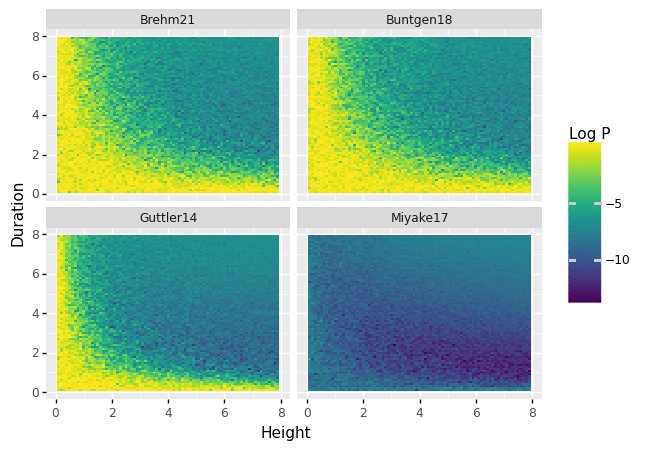

<ggplot: (8779047631351)>

In [ ]:
(ggplot(simulations, aes(x="Height", y="Duration", fill="Log P"))
    + geom_tile()
    + scale_color_cmap(cmap_name="Spectral")
    + facet_wrap(~ "Model" + "Data"))

Kernel density information will enable me to get the maximum likelhood as well as the mean and median.

In [36]:
import os

# So the new plan is to webscrape the list of data_set names
# So I want to write a recursive file opening function 

data_sets = []  # Storing the paths to the data sets

data_sets_directory = "{}/datasets".format(os.getcwd()) # Home directory of the data 
for yearly_data_directory in os.listdir(data_sets_directory):   # Looping through each year of data 
    yearly_data_directory = f"{data_sets_directory}/{yearly_data_directory}"    # Updating the path 
    hemispheres = os.listdir(yearly_data_directory) # Finding the hemispheres present in the data year
    for hemisphere in hemispheres:  # Looping over the present hemispheres 
        hemisphere_directory = f"{yearly_data_directory}/{hemisphere}"  # Extending the dirname 
        year_hemisphere_data = os.listdir(hemisphere_directory) # Finding the data names 
        for year_hemisphere in year_hemisphere_data:
            data_sets.append(f"{hemisphere_directory}/{year_hemisphere}")


In [41]:
len(os.walk(data_sets_directory))

TypeError: object of type 'generator' has no len()

In [50]:
for (root, dirs, files) in os.walk(data_sets_directory):
   if []:
       data_sets.extend(files)